In [ ]:
#Importação de pacotes
import warnings
import pandas as pd
df = pd.read_csv('madrid.csv')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
df.head(1)

In [ ]:
df.info()

# TRADUÇÃO DA BASE DE DADOS

In [ ]:
df_traduzida = df.rename(columns={'company':'empresa','origin':'Origem','destination':'Destino','vehicle_type':'TipoVeículo','vehicle_class':'ClasseVeículo','price':'Preço','fare':'Tarifa'})

# MANIPULAÇÃO E TRATEMENTO DE DADOS

### EXCLUINDO COLUNAS NÃO SERÃO ÚTEIS

In [5]:
del df_traduzida['id']
del df_traduzida['duration']
del df_traduzida['seats']
del df_traduzida['meta']
del df_traduzida['arrival']
del df_traduzida['insert_date']

###  TRATANDO VALORES NULOS E DUPLICADOS

In [6]:
(df_traduzida.isnull().sum() / len(df_traduzida['Preço']))*100

empresa          0.00
Origem           0.00
Destino          0.00
departure        0.00
TipoVeículo      0.00
ClasseVeículo   20.73
Preço           23.64
Tarifa          20.73
dtype: float64

In [7]:
m = df_traduzida['Preço'].median()
df_traduzida['Preço'] = df_traduzida['Preço'].fillna(m)

In [8]:
valor_padrao = 'Valor_Padrao'
df_traduzida['ClasseVeículo'].fillna(valor_padrao, inplace=True)

In [9]:
valor_padrao = 'Valor_Padrao'
df_traduzida['Tarifa'].fillna(valor_padrao, inplace=True)

In [10]:
df_traduzida.duplicated().sum()

38345742

In [11]:
df_traduzida = df_traduzida.drop_duplicates()

In [12]:
df_traduzida.shape

(407318, 8)

# ANÁLISE EXPLORATÓRIA

## ESTATÍSTICA

In [13]:
df_traduzida.describe()

,Preço
count,407318.00
mean,58.42
std,25.41
min,0.00
25%,41.80
50%,55.70
75%,69.30
max,342.80


### MODA

In [14]:
from statistics import mode
mode(df_traduzida['Preço'])

55.7

### ASSIMETRIA

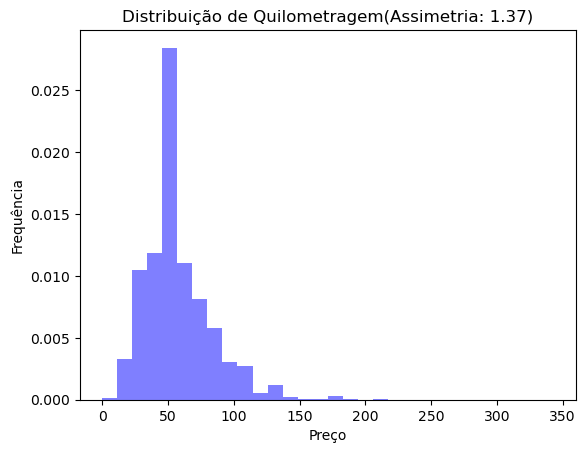

In [15]:
from scipy.stats import skew

Preço = df_traduzida['Preço']

# Calculando a assimetria dos dados
assimetria = skew(Preço)

# Criando um histograma para visualizar a distribuição dos dados
plt.hist(Preço, bins=30, density=True, alpha=0.5, color='b')

# Adicionando informações ao gráfico
plt.title(f'Distribuição de Quilometragem(Assimetria: {assimetria:.2f})')
plt.xlabel('Preço')
plt.ylabel('Frequência')

# Exibindo o gráfico
plt.show()


### CURTOSE

In [16]:
df_traduzida['Preço'].kurt()

4.132153276099654

### TOTAL DE VALORES UNICOS EM CADA VARIAVEL

In [17]:
valores_unicos = []
for i in df_traduzida.columns[0:12].tolist():
    print(i, ':', len(df_traduzida[i].astype(str).value_counts()))
    valores_unicos.append(len(df_traduzida[i].astype(str).value_counts()))

empresa : 1
Origem : 30
Destino : 30
departure : 89461
TipoVeículo : 30
ClasseVeículo : 12
Preço : 1495
Tarifa : 13


### VERIFICANDO SE HÁ POSSIBILIDADE DE OUTLIERS E TRATAMENTO DO MESMO

Preço : float64


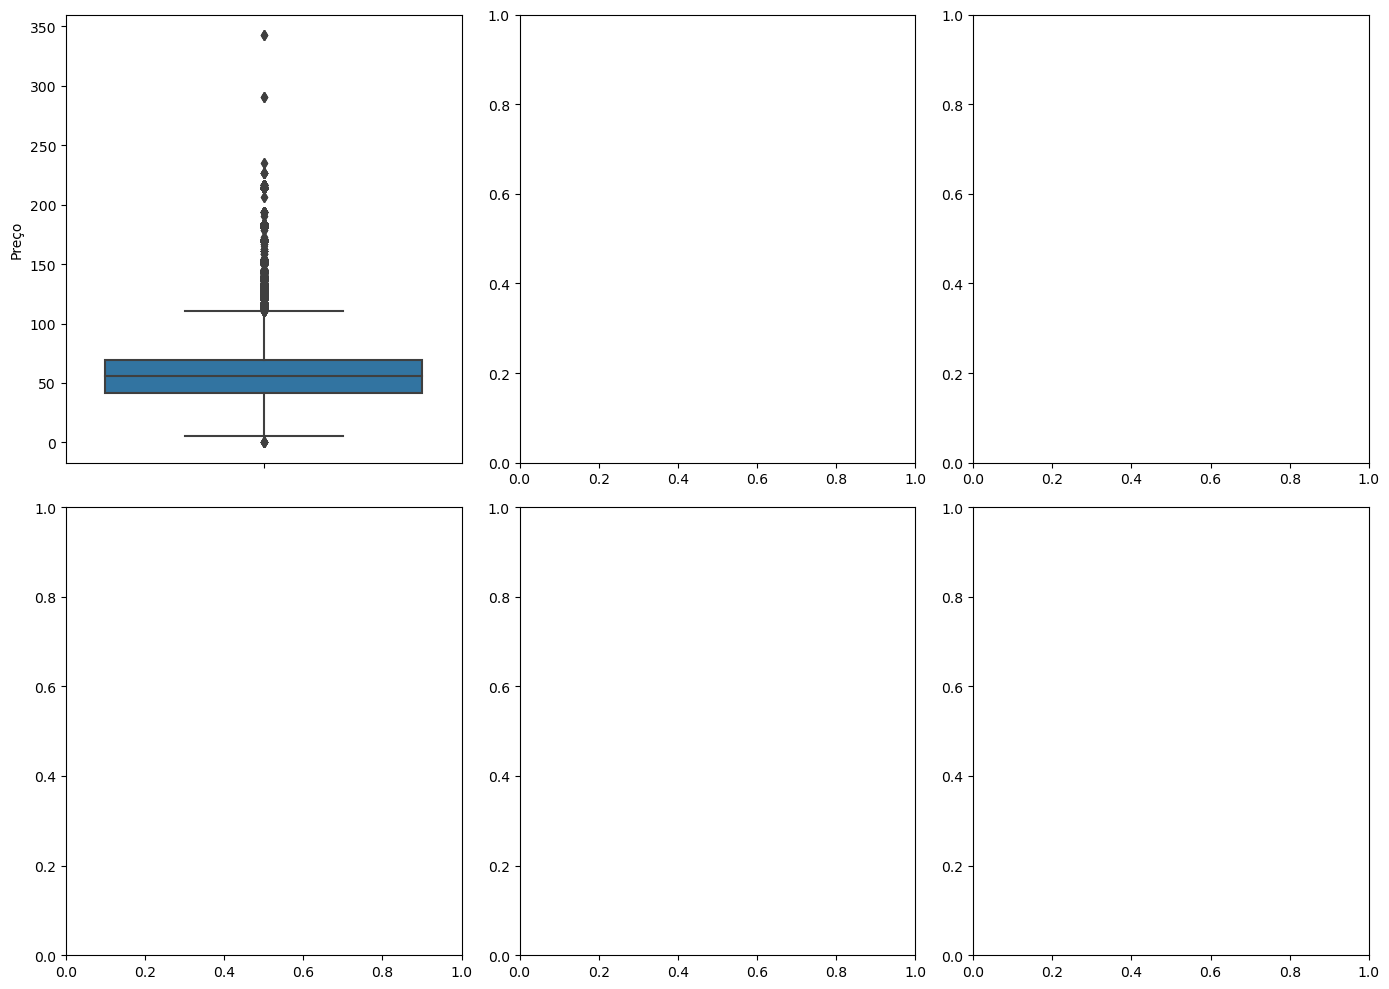

In [18]:
variaveis_numericas = []
for i in df_traduzida.columns[0:16].tolist():
        if df_traduzida.dtypes[i] == 'int64' or df_traduzida.dtypes[i] == 'float64':            
            print(i, ':' , df_traduzida.dtypes[i]) 
            variaveis_numericas.append(i)
 
    
    
    
plt.rcParams["figure.figsize"] = [14.00, 10.00]
plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 10 
plt.rcParams['axes.titlesize'] = 20

f, axes = plt.subplots(2, 3) #8 linhas e 4 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_traduzida, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 3:
        linha += 1
        coluna = 0            

plt.show() 

### ANALISANDO DADOS COM PYHWALKER

In [19]:
import pygwalker as pyg
pyg.walk(df_traduzida)

Box(children=(HTML(value='<div id="ifr-pyg-0" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

# ANÁLISE DE DADOS

In [20]:
df_traduzida.head(1)

,empresa,Origem,Destino,departure,TipoVeículo,ClasseVeículo,Preço,Tarifa
0,renfe,MADRID,BARCELONA,2019-04-18 05:50:00,AVE,Preferente,68.95,Promo


### AGRUPAMENTO DE DADOS 

In [21]:
df_traduzida.groupby(df_traduzida['Origem']).size()

Origem
ALBACETE         7300
ALICANTE         5357
BARCELONA       48502
CADIZ             881
CASTELLO          173
CASTELLON        4357
CIUDAD REAL      1598
CORDOBA         12891
CUENCA           1416
CÓRDOBA          1355
GIRONA           5425
GRANADA          2182
GUADALAJARA       729
HUESCA            365
LEON             3903
LEÓN              606
LLEIDA           5104
MADRID         198345
MALAGA           5370
MÁLAGA            506
PALENCIA         1482
PONFERRADA       5921
SEGOVIA          2031
SEVILLA         29204
TARRAGONA        7301
TOLEDO            867
VALENCIA        31122
VALLADOLID       8505
ZAMORA            480
ZARAGOZA        14040
dtype: int64

In [22]:
df_traduzida.groupby(df_traduzida['Destino']).size()

Destino
ALBACETE         7206
ALICANTE         5408
BARCELONA       48913
CADIZ             812
CASTELLO          494
CASTELLON        4192
CIUDAD REAL      1524
CORDOBA         11460
CUENCA           1441
CÓRDOBA          1367
GIRONA           4742
GRANADA          2159
GUADALAJARA       777
HUESCA            302
LEON             3061
LEÓN              600
LLEIDA           4027
MADRID         203500
MALAGA           5552
MÁLAGA            518
PALENCIA         1561
PONFERRADA       4135
SEGOVIA          1969
SEVILLA         28363
TARRAGONA        7139
TOLEDO            859
VALENCIA        33244
VALLADOLID       8677
ZAMORA            477
ZARAGOZA        12839
dtype: int64

In [23]:
df_traduzida.groupby(df_traduzida['TipoVeículo']).size()

TipoVeículo
ALTARIA        2517
ALVIA         33718
AV City        8640
AVANT         12065
AVANT-AVE      2408
AVANT-LD        155
AVANT-MD        321
AVE          268610
AVE-AVANT      1217
AVE-AVE         198
AVE-LD        13442
AVE-MD         3400
AVE-TGV        5320
AVLO           1107
EUROMED        1354
INTERCITY      9305
Intercity      1396
LD             3156
LD-AVANT        330
LD-AVE         8902
LD-MD          2972
MD             8213
MD-AVANT        288
MD-AVE         4741
MD-LD          4859
R. EXPRES       375
REG.EXP.       2132
REGIONAL       4139
TORRE ORO       359
TRENHOTEL      1679
dtype: int64

In [24]:
df_traduzida.groupby(df_traduzida['ClasseVeículo']).size()

ClasseVeículo
Cama G. Clase                   36
Cama Turista                   254
Preferente                   41756
PreferenteSólo plaza H         248
Turista                     242817
Turista - Turista Plus          82
Turista Plus                 27746
Turista Plus - Turista         137
Turista PlusSólo plaza H        13
Turista con enlace           35531
TuristaSólo plaza H           4524
Valor_Padrao                 54174
dtype: int64

In [25]:
df_traduzida.groupby(df_traduzida['Tarifa']).size()

Tarifa
4x100                           1
Adulto ida                  21990
Básica                       1032
COD.PROMOCIONAL              3374
Doble Familiar-Flexible        20
Flexible                    93459
Grupos Ida                     35
Individual-Flexible            16
Mesa                           11
Promo                      172501
Promo +                     55222
Valor_Padrao                54174
YOVOY                        5483
dtype: int64

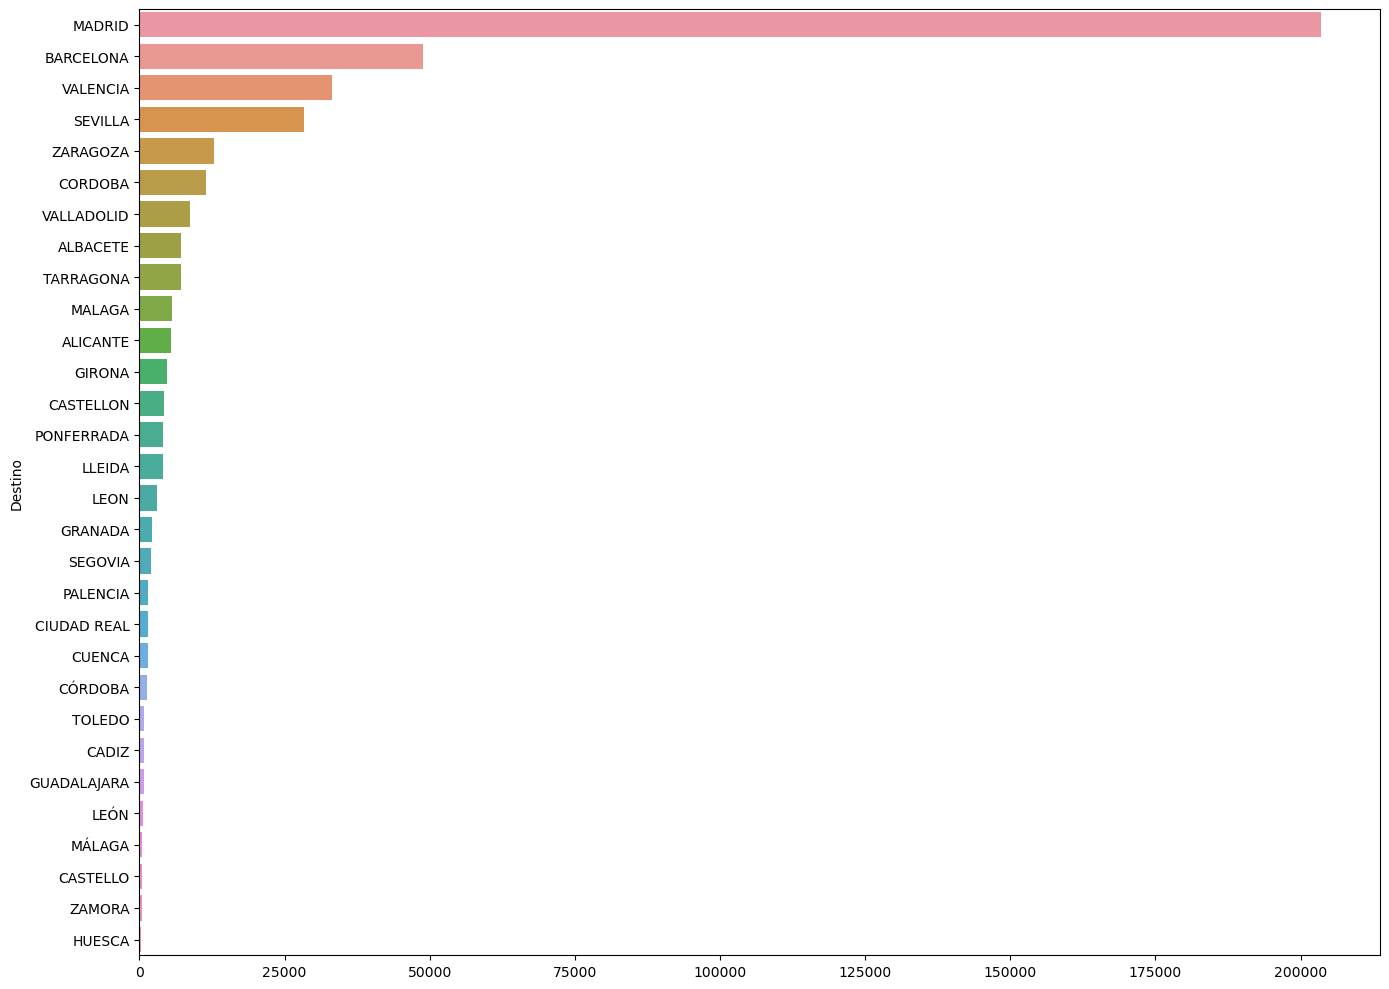

In [26]:
# Identificando os modelos mais vendidos
x = df_traduzida['Destino'].value_counts().values
y = df_traduzida['Destino'].value_counts().index
sns.barplot( x=x, y=y ) 
plt.show()

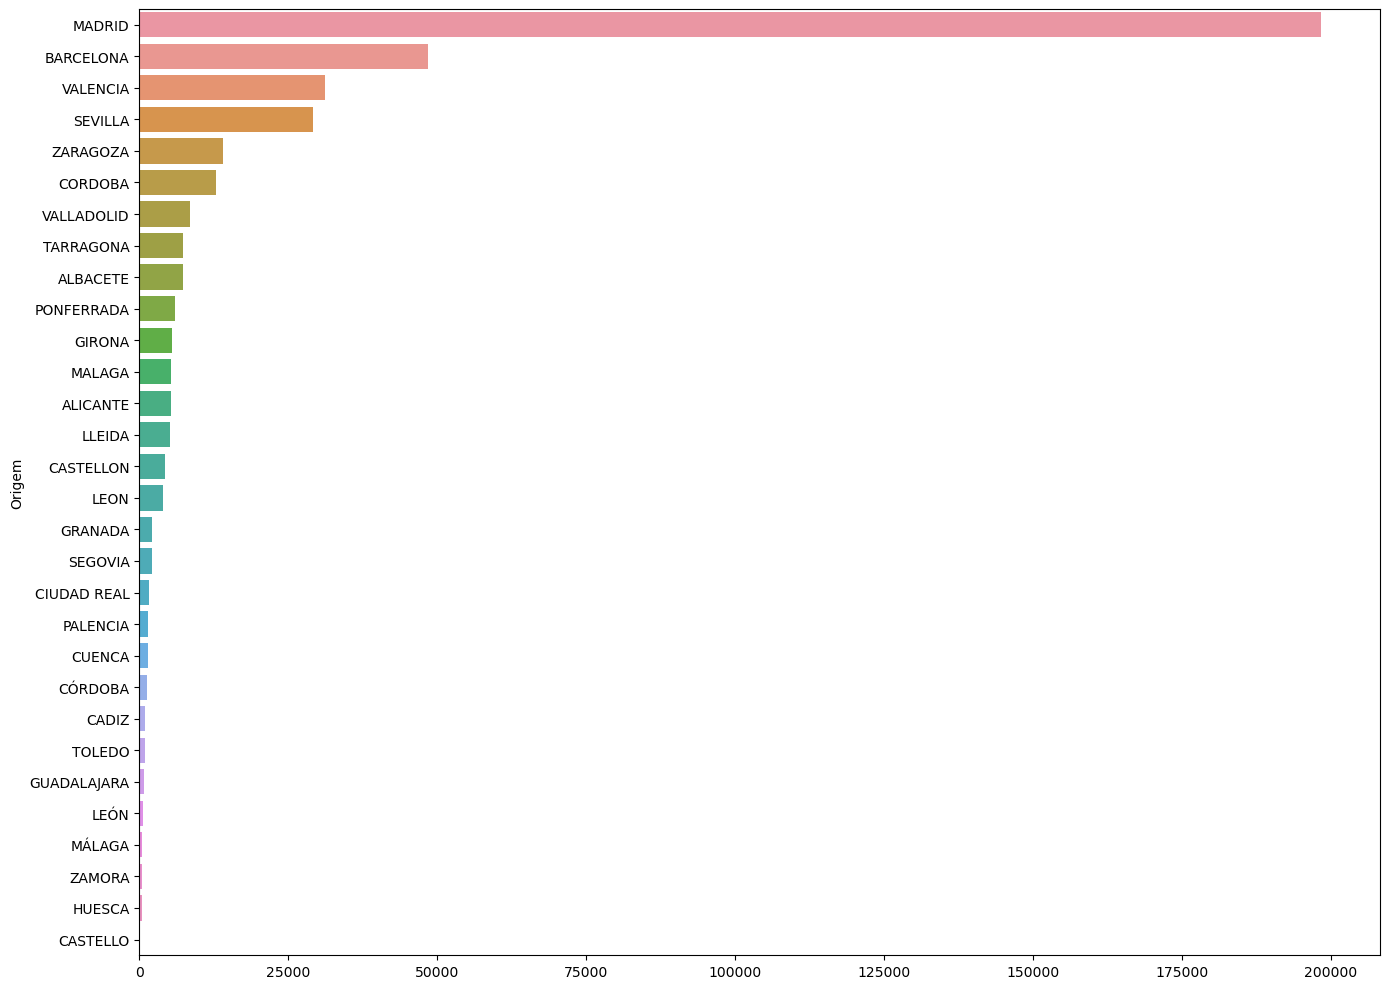

In [27]:
# Identificando os modelos mais vendidos
x = df_traduzida['Origem'].value_counts().values
y = df_traduzida['Origem'].value_counts().index
sns.barplot( x=x, y=y ) 
plt.show()

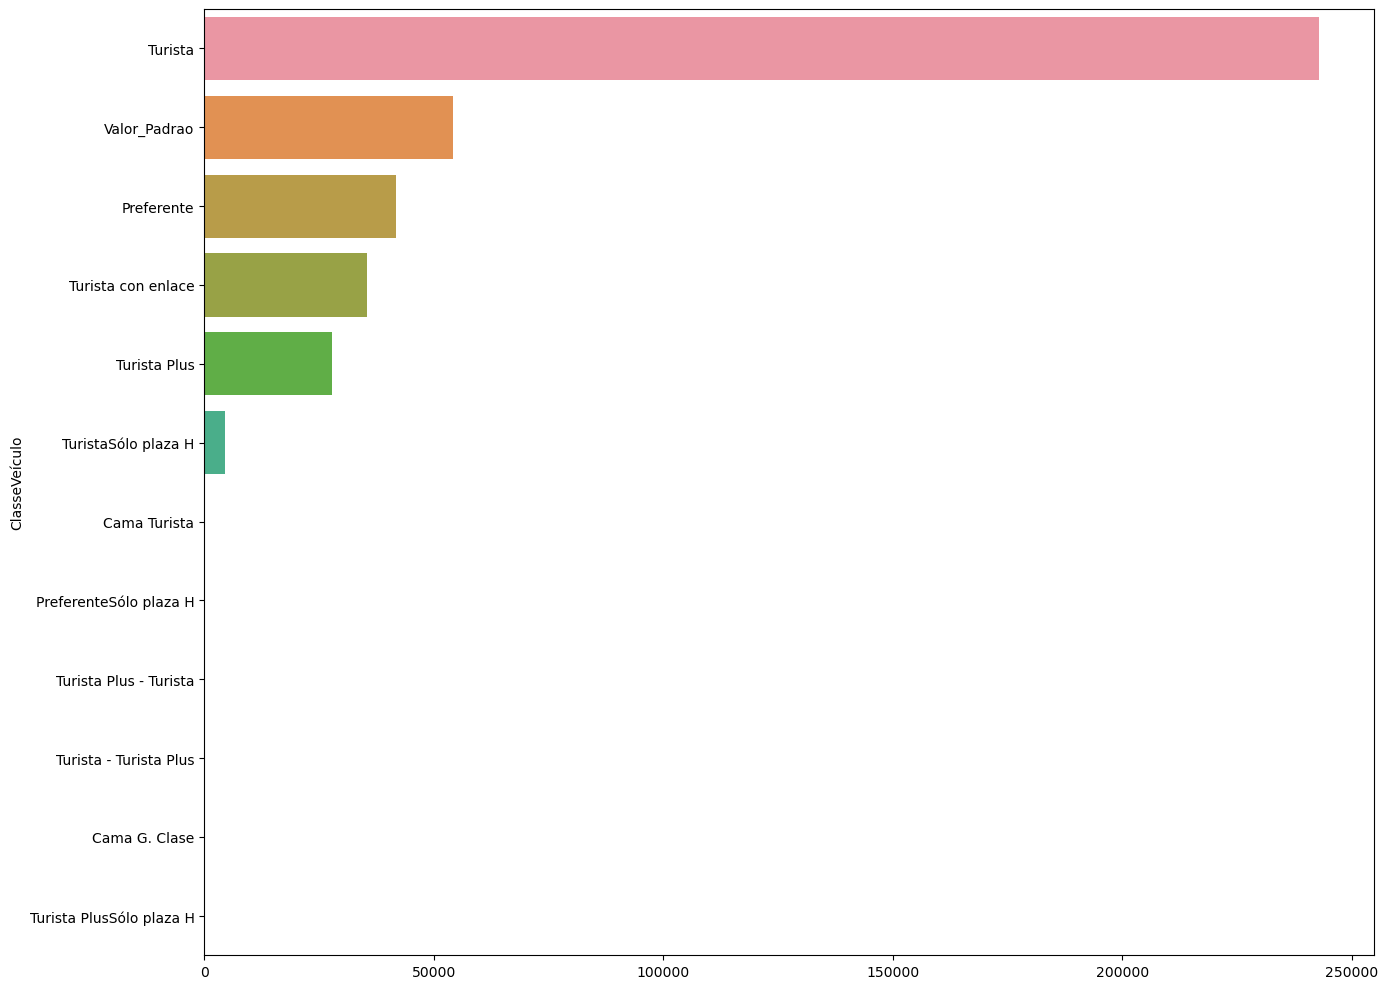

In [28]:
# Identificando os modelos mais vendidos
x = df_traduzida['ClasseVeículo'].value_counts().values
y = df_traduzida['ClasseVeículo'].value_counts().index
sns.barplot( x=x, y=y ) 
plt.show()

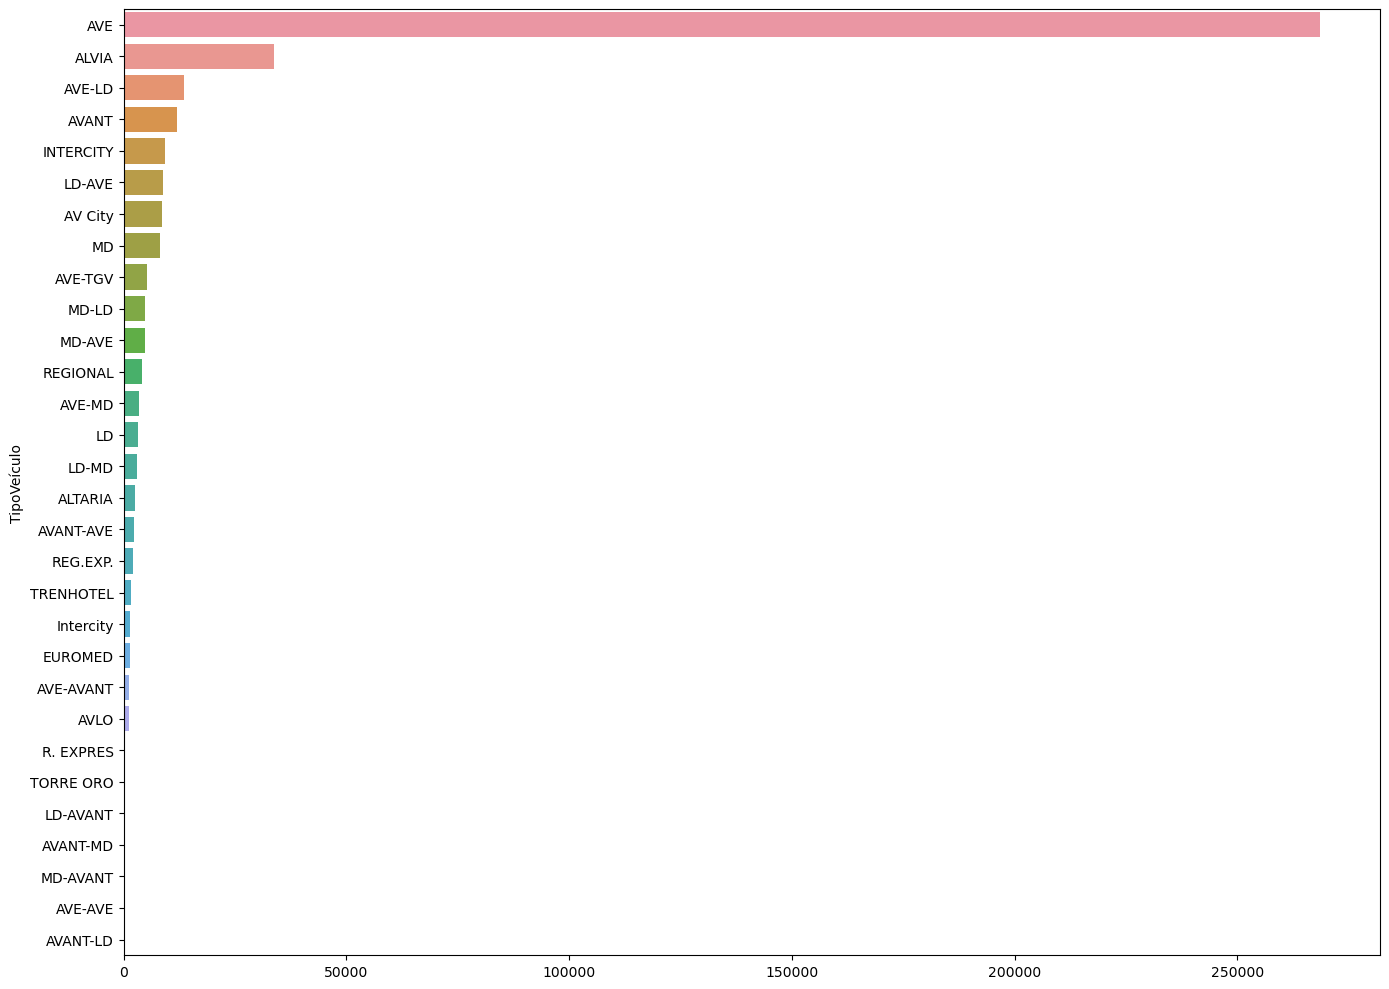

In [29]:
# Identificando os modelos mais vendidos
x = df_traduzida['TipoVeículo'].value_counts().values
y = df_traduzida['TipoVeículo'].value_counts().index
sns.barplot( x=x, y=y ) 
plt.show()

## ANALISANDO AS DATAS DAS PARTIDAS

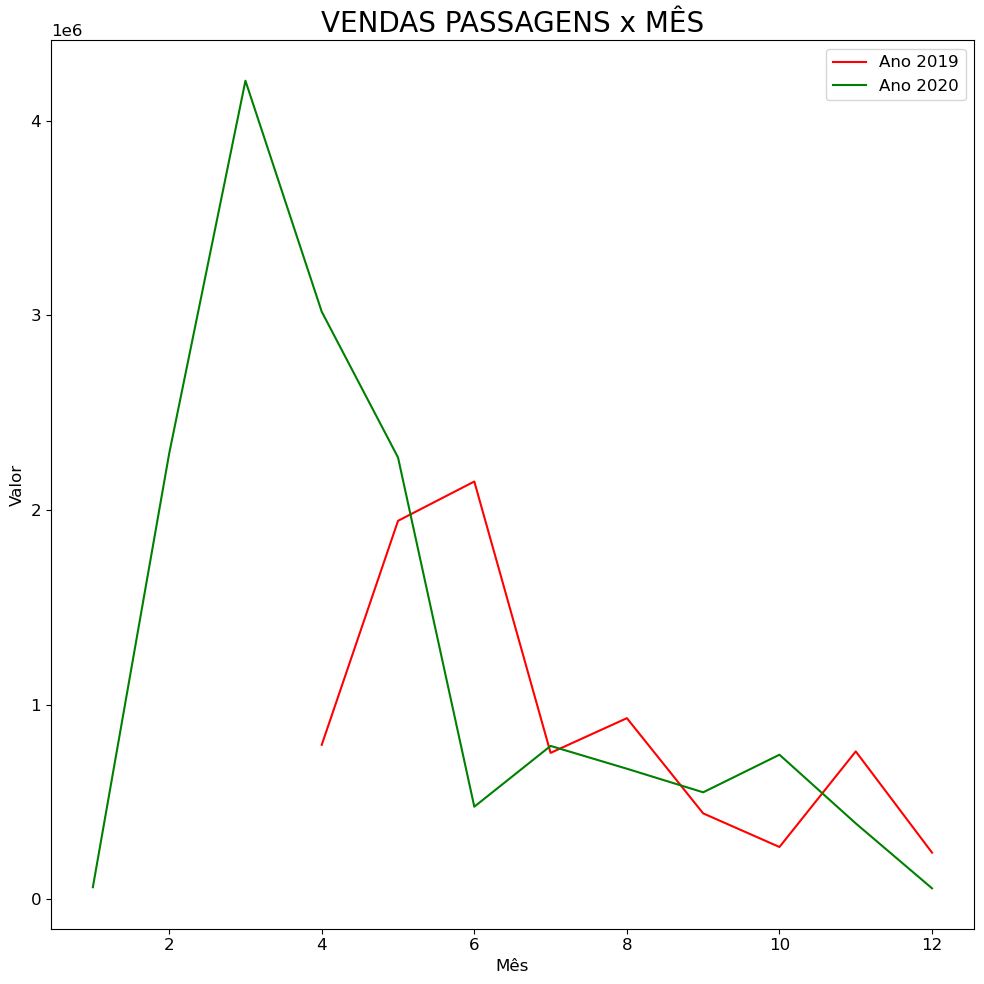

In [30]:
#Agora podemos exibir um gráfico comparativo entre as vendas de 2020 e 2021

# Reiniciando o matplotlib
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

# Formatando tamanho do grafico
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.titlesize'] = 20


#Convertendo o campo DATA_VENDA para DateTime
df_traduzida['departure'] = pd.to_datetime(df_traduzida['departure'], format="%Y-%m-%d %H:%M:%S")

#Selecionando apenas as vendas de 2021
df_2019 = df_traduzida[df_traduzida["departure"].dt.year == 2019]

#Selecionando apenas as vendas de 2021
df_2020 = df_traduzida[df_traduzida["departure"].dt.year == 2020]

# Comparativo de lucro bruto por mês
df_2019.groupby(df_2019["departure"].dt.month)["Preço"].sum().plot(color='red', label='Ano 2019')
df_2020.groupby(df_2020["departure"].dt.month)["Preço"].sum().plot(color='green', label='Ano 2020')
plt.title("VENDAS PASSAGENS x MÊS")
plt.ylabel("Valor")
plt.xlabel("Mês")

plt.legend()
plt.show()

#  ANALISANDO 2019

In [31]:
df_2019.groupby(df_2019["departure"].dt.month).agg({"Preço": "sum"}).style.format("{:,.2f}")

,Preço
departure,
4,"793,697.30"
5,"1,944,216.04"
6,"2,146,120.47"
7,"752,485.98"
8,"930,706.81"
9,"441,658.87"
10,"269,096.57"
11,"759,992.74"
12,"240,041.58"


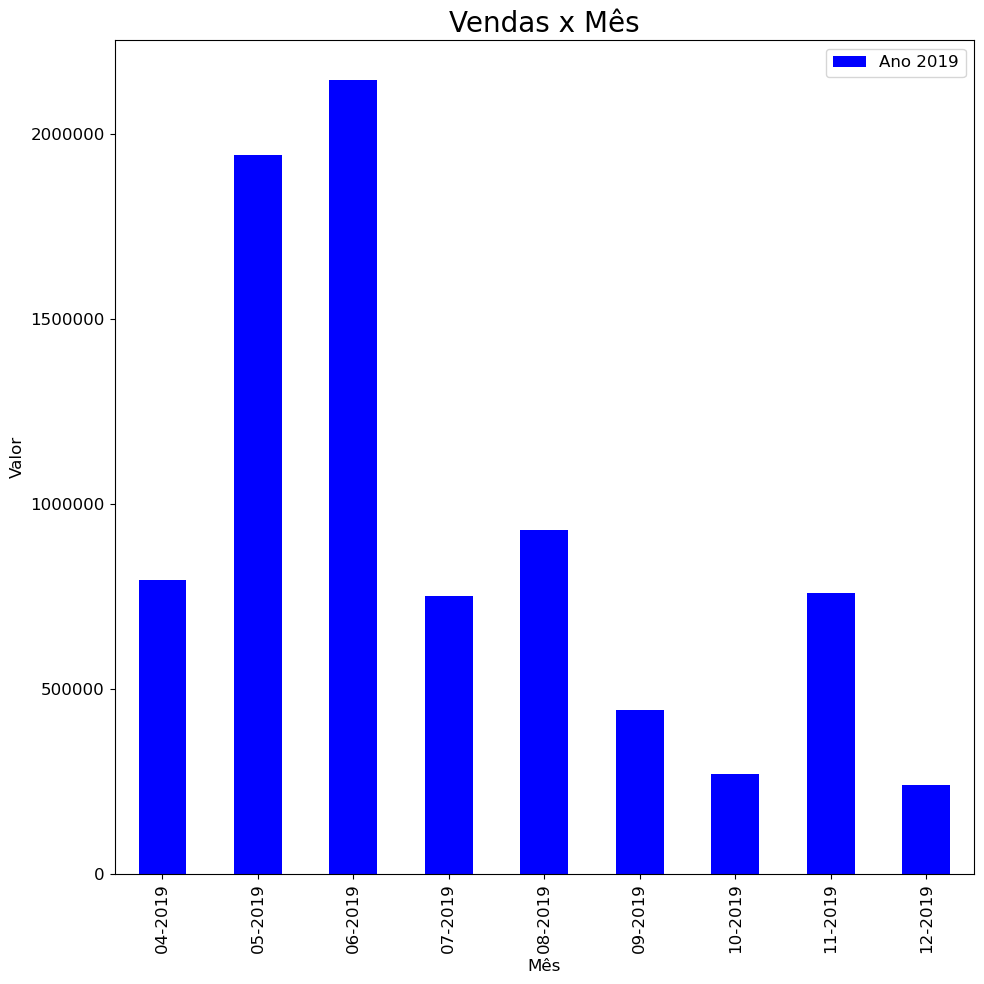

In [32]:

df_2019.groupby(df_2019["departure"].dt.strftime('%m-%Y'))["Preço"].sum().plot.bar(color='blue', label='Ano 2019')

import matplotlib.ticker as tick
plt.ticklabel_format(style='plain', axis='y')
plt.title("Vendas x Mês")
plt.ylabel("Valor")
plt.xlabel("Mês")
plt.legend()
ax = plt.gca()


In [33]:
df_2019.head(1)

,empresa,Origem,Destino,departure,TipoVeículo,ClasseVeículo,Preço,Tarifa
0,renfe,MADRID,BARCELONA,2019-04-18 05:50:00,AVE,Preferente,68.95,Promo


## ANALISANDO OS LUCROS, MÉDIA, QUANTIDADE DAS PASSAGENS VENDIDAS 2019

### ORIGEM DAS PASSAGENS

In [34]:
total_compras = df_2019.groupby(["Origem"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2019.groupby(["Origem"])["Preço"].mean().rename("Média das Passagens")
numero = df_2019.groupby(["Origem"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
Origem,,,
MADRID,"$4,150,803.24",$67.05,61902
BARCELONA,"$2,153,432.51",$88.53,24325
SEVILLA,"$1,011,238.65",$58.24,17364
VALENCIA,"$748,262.09",$47.51,15748
PONFERRADA,"$187,890.25",$47.08,3991


### DESTINO DAS PASSAGENS

In [35]:
total_compras = df_2019.groupby(["Destino"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2019.groupby(["Destino"])["Preço"].mean().rename("Média das Passagens")
numero = df_2019.groupby(["Destino"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
Destino,,,
MADRID,"$4,127,213.12",$66.68,61897
BARCELONA,"$2,112,121.79",$88.19,23950
VALENCIA,"$877,908.47",$48.82,17984
SEVILLA,"$1,011,829.66",$60.17,16817
PONFERRADA,"$128,139.65",$46.19,2774


### TIPO DE VEICULO DAS PASSAGENS

In [36]:
total_compras = df_2019.groupby(["TipoVeículo"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2019.groupby(["TipoVeículo"])["Preço"].mean().rename("Média das Passagens")
numero = df_2019.groupby(["TipoVeículo"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
TipoVeículo,,,
AVE,"$6,686,262.15",$72.35,92418
ALVIA,"$447,701.00",$54.64,8193
INTERCITY,"$212,487.31",$38.44,5528
AV City,"$151,152.71",$51.80,2918
MD-LD,"$96,792.70",$43.52,2224


### CLASSE DE VEICULO DAS PASSAGENS

In [37]:
total_compras = df_2019.groupby(["ClasseVeículo"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2019.groupby(["ClasseVeículo"])["Preço"].mean().rename("Média das Passagens")
numero = df_2019.groupby(["ClasseVeículo"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
ClasseVeículo,,,
Turista,"$4,554,055.18",$59.45,76600
Preferente,"$1,914,055.62",$88.04,21741
Turista Plus,"$1,054,907.51",$81.79,12897
Turista con enlace,"$296,429.85",$46.44,6383
TuristaSólo plaza H,"$358,651.00",$79.28,4524


### TARIFAS DAS PASSAGENS

In [38]:
total_compras = df_2019.groupby(["Tarifa"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2019.groupby(["Tarifa"])["Preço"].mean().rename("Média das Passagens")
numero = df_2019.groupby(["Tarifa"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
Tarifa,,,
Promo,"$5,177,330.16",$62.20,83232
Flexible,"$2,636,234.80",$84.78,31096
COD.PROMOCIONAL,"$194,665.10",$57.70,3374
Adulto ida,"$104,158.90",$38.89,2678
Promo +,"$92,545.30",$42.47,2179


#  ANALISANDO 2020

In [39]:

df_2020.groupby(df_2020["departure"].dt.month).agg({"Preço": "sum"}).style.format("{:,.2f}")

,Preço
departure,
1,"62,468.57"
2,"2,289,223.39"
3,"4,204,574.55"
4,"3,018,232.14"
5,"2,269,822.35"
6,"475,983.40"
7,"788,132.12"
8,"671,016.78"
9,"549,904.66"


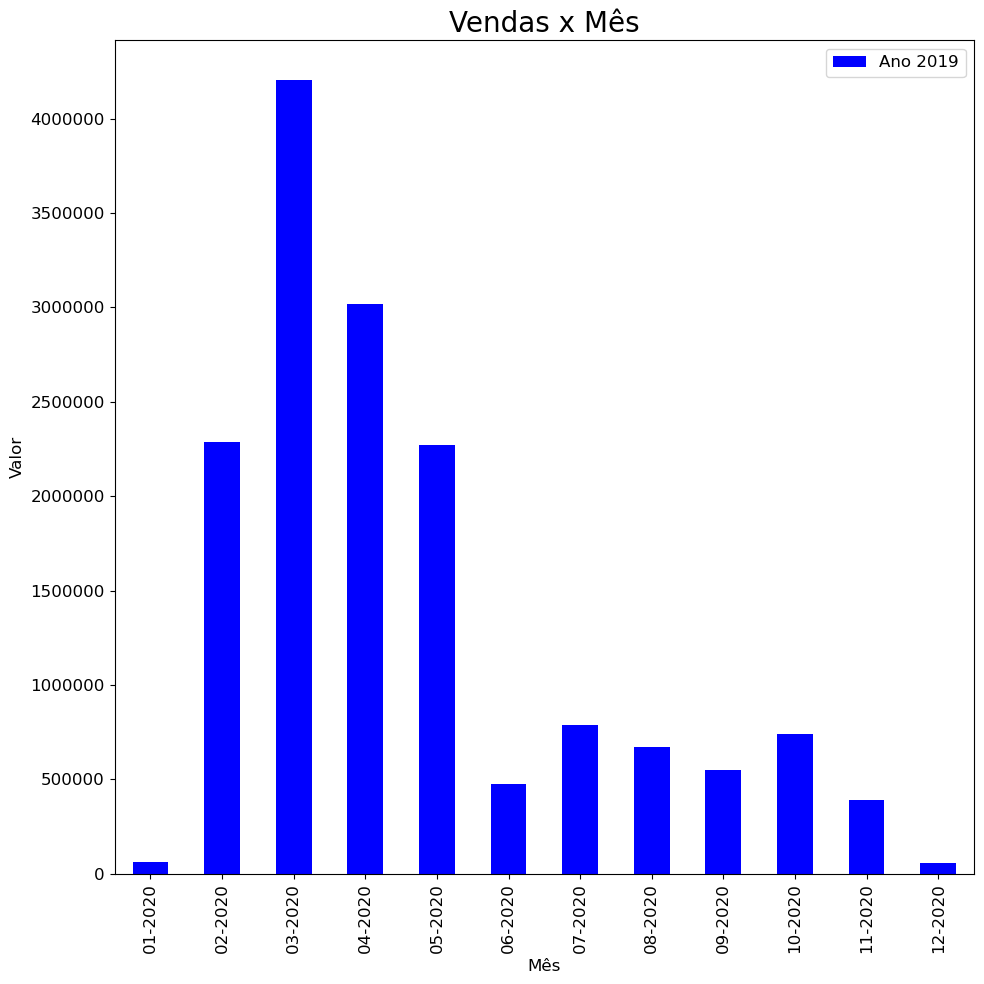

In [40]:

df_2020.groupby(df_2020["departure"].dt.strftime('%m-%Y'))["Preço"].sum().plot.bar(color='blue', label='Ano 2019')

import matplotlib.ticker as tick
plt.ticklabel_format(style='plain', axis='y')
plt.title("Vendas x Mês")
plt.ylabel("Valor")
plt.xlabel("Mês")
plt.legend()
ax = plt.gca()

## ANALISANDO OS LUCROS, MÉDIA, QUANTIDADE DAS PASSAGENS VENDIDAS 2020

In [41]:
df_2020.head(1)

,empresa,Origem,Destino,departure,TipoVeículo,ClasseVeículo,Preço,Tarifa
15390526,renfe,VALENCIA,MADRID,2020-01-02 09:40:00,AVE,Valor_Padrao,55.70,Valor_Padrao


### ORIGEM DAS PASSAGENS

In [42]:
total_compras = df_2020.groupby(["Origem"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2020.groupby(["Origem"])["Preço"].mean().rename("Média das Passagens")
numero = df_2020.groupby(["Origem"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
Origem,,,
MADRID,"$7,516,205.92",$55.09,136443
BARCELONA,"$1,774,276.95",$73.39,24177
VALENCIA,"$725,021.50",$47.16,15374
ZARAGOZA,"$666,214.49",$47.45,14040
CORDOBA,"$709,279.68",$55.02,12891


### DESTINO DAS PASSAGENS

In [43]:
total_compras = df_2020.groupby(["Destino"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2020.groupby(["Destino"])["Preço"].mean().rename("Média das Passagens")
numero = df_2020.groupby(["Destino"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
Destino,,,
MADRID,"$7,787,393.04",$54.99,141603
BARCELONA,"$1,817,597.43",$72.81,24963
VALENCIA,"$705,508.34",$46.23,15260
ZARAGOZA,"$612,012.35",$47.67,12839
SEVILLA,"$707,839.26",$61.31,11546


### TIPO DE VEICULO DAS PASSAGENS

In [44]:
total_compras = df_2020.groupby(["TipoVeículo"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2020.groupby(["TipoVeículo"])["Preço"].mean().rename("Média das Passagens")
numero = df_2020.groupby(["TipoVeículo"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
TipoVeículo,,,
AVE,"$10,658,263.00",$60.49,176192
ALVIA,"$1,157,363.09",$45.34,25525
AVANT,"$368,575.10",$30.55,12065
AVE-LD,"$616,388.35",$54.42,11326
MD,"$301,278.65",$37.15,8109


### CLASSE DE VEICULO DAS PASSAGENS

In [45]:
total_compras = df_2020.groupby(["ClasseVeículo"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2020.groupby(["ClasseVeículo"])["Preço"].mean().rename("Média das Passagens")
numero = df_2020.groupby(["ClasseVeículo"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
ClasseVeículo,,,
Turista,"$8,518,496.86",$51.25,166217
Valor_Padrao,"$2,952,044.30",$55.70,52999
Turista con enlace,"$1,593,281.45",$54.66,29148
Preferente,"$1,470,451.26",$73.47,20015
Turista Plus,"$969,486.78",$65.29,14849


### TARIFAS DAS PASSAGENS

In [46]:
total_compras = df_2020.groupby(["Tarifa"])["Preço"].sum().rename("Total Dos Passagens")
media_compra = df_2020.groupby(["Tarifa"])["Preço"].mean().rename("Média das Passagens")
numero = df_2020.groupby(["Tarifa"])["Preço"].count().rename('Número das Passagens')
# Dataframe para os resultados
dados_usuarios = pd.DataFrame({"Total Dos Passagens": total_compras, "Média das Passagens":media_compra,"Número das Passagens":numero})

# Manipulação de Dados
dados_usuarios ["Total Dos Passagens"] = dados_usuarios["Total Dos Passagens"].map("${:,.2f}".format)
dados_usuarios ["Média das Passagens"] = dados_usuarios["Média das Passagens"].map("${:,.2f}".format)
dados_usuarios.sort_values("Número das Passagens", ascending=False).head(5)

,Total Dos Passagens,Média das Passagens,Número das Passagens
Tarifa,,,
Promo,"$4,702,745.14",$52.68,89269
Flexible,"$4,275,094.30",$68.55,62363
Promo +,"$2,770,038.13",$52.22,53043
Valor_Padrao,"$2,952,044.30",$55.70,52999
Adulto ida,"$515,960.40",$26.72,19312


# MACHINE LEARNING 

## PRÉ PROCESSAMENTO DOS DADOS

### EXCLUINDO VARIAVEIS NÃO ÚTEIS PARA O MODELO

In [47]:
del df_traduzida['departure']
del df_traduzida['empresa']

In [48]:
# Cria o encoder
lb = LabelEncoder()
df_traduzida['Origem'] = lb.fit_transform(df_traduzida['Origem'])
df_traduzida['Destino'] = lb.fit_transform(df_traduzida['Destino'])
df_traduzida['TipoVeículo'] = lb.fit_transform(df_traduzida['TipoVeículo'])
df_traduzida['ClasseVeículo'] = lb.fit_transform(df_traduzida['ClasseVeículo'])
df_traduzida['Tarifa'] = lb.fit_transform(df_traduzida['Tarifa'])

# Remove valores missing eventualmente gerados
df_traduzida.dropna(inplace = True)

In [49]:
df_traduzida = df_traduzida[['Origem','Destino','TipoVeículo','ClasseVeículo','Tarifa','Preço']]

In [50]:
# SEPRANDO AS VARIAVEIS PARA TREINAMENTO

X = df_traduzida.iloc[:, :-1]
y = df_traduzida.iloc[:, -1]

In [51]:
# Train Test Split:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [52]:

# check xgboost version
from xgboost import XGBRegressor

# Criando o modelo
modelo1 = XGBRegressor()

# Treinando o modelo
modelo1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [53]:
# Fazendo previsões
y_predI = modelo1.predict(X_test)
previsoes = [round(value) for value in y_predI]

In [54]:
# Scores:
print(r2_score(y_test, y_predI))

# Calculando o Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_predI)

# Calculando o Coeficiente de Determinação (R²)
r2 = r2_score(y_test, y_predI)

#Erro Médio Absoluto (MAE): 
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_predI)

print("#Erro Médio Absoluto (MAE): %.2f" % mae)
print("Mean Squared Error (MSE): %.2f" % mse)
print("Coeficiente de Determinação (R²): %.2f" % r2)

0.8061510860849348
#Erro Médio Absoluto (MAE): 6.59
Mean Squared Error (MSE): 126.34
Coeficiente de Determinação (R²): 0.81


### MELHORANDO O MODELO DE MACHINE LEARNING

In [55]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Criar uma instância do modelo XGBoost para regressão
model = XGBRegressor()

# Definir os parâmetros que deseja otimizar
param_dist = {
    'learning_rate': np.arange(0.01, 0.31, 0.05),
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(3, 10, 1),
    'min_child_weight': range(1, 6, 1),
    'gamma': [i/10.0 for i in range(0, 5)],
    'subsample': np.arange(0.6, 1.0, 0.1),
    'colsample_bytree': np.arange(0.6, 1.0, 0.1),
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

# Criar o objeto RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Treinar o modelo
random_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores hiperparâmetros: {'subsample': 0.8999999999999999, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.16000000000000003, 'gamma': 0.3, 'colsample_bytree': 0.8999999999999999}


In [56]:
# Melhor modelo com os hiperparâmetros otimizados
best_model = random_search.best_estimator_

# Prever os valores para o conjunto de validação/teste

y_predIto = best_model.predict(X_test)  # Substitua X_valid pelos seus dados de validação/teste

# Calcular as métricas de avaliação, por exemplo, o erro médio quadrático (MSE)


mse = mean_squared_error(y_test, y_predIto)  # Substitua y_valid pelos seus valores verdadeiros]

r2a = r2_score(y_test, y_predIto)
print("Erro Médio Quadrático (MSE) no conjunto de validação:", mse)
print("Erro Médio Quadrático (MSE) no conjunto de validação:", r2a )

Erro Médio Quadrático (MSE) no conjunto de validação: 125.25288556668681
Erro Médio Quadrático (MSE) no conjunto de validação: 0.8078250634725698


In [ ]:
CompanhiaAérea = 3
CidadeOrigem = 2
Paradas = 0
CidadeDestino = 3
ClasseEconomica = 1
parametro = [[CompanhiaAérea,CidadeOrigem,CidadeDestino,ClasseEconomica,Paradas]]

fazendo_previsao = modelo.predict(parametro)

print('O PREÇO DA PASSAGEN SERÁ DE: ', fazendo_previsao)